# NOTEBOOK NAME
Created by: Thomas Durand-Texte, 2023

# Import des packages et données
## import des packages

In [270]:
import os

import pickle
import time

import pandas as pd
import numpy as np
# import dask as dd
pd.set_option("display.max_columns", 200)
import datetime as dt
import scipy.stats as st

from sklearn import model_selection, metrics, preprocessing, linear_model, dummy
from sklearn import svm

import matplotlib.pyplot as plt
import seaborn as sns

cm = 1./2.54

## Paramètres graphiques et fonctions utiles

In [271]:
import subprocess

white_font = True
def set_theme( white_font=True ):
    """ set_theme( white_font=True ) """
    if white_font: wht, grey, blck = '0.84' , '0.5', 'k'
    else: wht, grey, blck = 'k', '0.5', '0.84'
    rc = { 'figure.facecolor':(0.118,)*3,
            'axes.labelcolor':wht,
            'axes.edgecolor':wht,
            'axes.facecolor':(0,0,0,0),
            'text.color':'white',
            'text.usetex':False,
            'text.latex.preamble':r'\usepackage[cm]{sfmath} \usepackage{amsmath}' ,
            'font.family': 'sans-serif' ,
            'font.sans-serif': 'DejaVu Sans' ,
            'xtick.color':wht,
            'ytick.color':wht,
            "axes.grid" : True,
            "grid.color": (0.7,)*3,
            "grid.linewidth": 0.4,
            "grid.linestyle": (10,5),
            'legend.edgecolor':'0.2',
            'legend.facecolor':(0.2,0.2,0.2,0.6),
            # 'legend.framealpha':'0.6',
            'pdf.fonttype':42,
            'savefig.format':'pdf',
            'savefig.transparent':True,
            'figure.dpi':150, # for better agreemet figsize vs real size
        }

    sns.set_theme( 'notebook' , rc=rc )
    return


def make_folder( path_folder ):
    path_folder = path_folder.__str__()
    try:
        if os.path.isdir( path_folder ) : return
        os.makedirs(path_folder)
    except OSError:
        pass
    return

def concat_folders(*args, **kwargs):
    """ concat_folders(*args, **kwargs)
        concatenate folders in args (strings) """
    sPath = ''
    for arg in args:
        if arg == '..': sPath = sPath[:sPath[:-1].rfind(os.sep)+1]
        else: sPath += arg
        if sPath[-1] != os.sep: sPath += os.sep
    return sPath

class Path(object):
    """ Path( s_in='', s_lim=None)
        create a path to the string s_in (default is current path)
        and stops after s_lim """
    n_Path = 0
    def __init__(self, s_in='', s_lim=None):
        """docstring."""
        if s_in == '': s_in = os.getcwd()
        if not s_lim is None:
            if s_lim in s_in:
                s_in = s_in[ :s_in.index( s_lim ) + len(s_lim) ]
        self.sPath = concat_folders(s_in)
        self.N = Path.n_Path
        Path.n_Path += 1

    def __add__(self, other):
        """ Path + str : return str """
        if isinstance(other, str): return self.sPath + other

    def __truediv__(self, other):
        """ Path / str : return path concatenated"""
        if isinstance(other, str): return Path(concat_folders(self.sPath, other))

    def __invert__(self):
        """ ~Path : return str of the path """
        return self.sPath

    def __str__(self):
        """ __str__ return str of the path """
        return self.sPath
    # __str__ #

    def makedir( self ):
        return make_folder( self )


def gs_opt( filename ):
    """ otpimisation of a pdf file with gosthscript """
    filenameTmp = filename.replace('.pdf', '') + '_tmp.pdf'
    gs = ['gs',
            '-sDEVICE=pdfwrite',
            '-dEmbedAllFonts=true',
            '-dSubsetFonts=true',             # Create font subsets (default)
            '-dPDFSETTINGS=/prepress',        # Image resolution
            '-dDetectDuplicateImages=true',   # Embeds images used multiple times only once
            '-dCompressFonts=true',           # Compress fonts in the output (default)
            '-dNOPAUSE',                      # No pause after each image
            '-dQUIET',                        # Suppress output
            '-dBATCH',                        # Automatically exit
            '-sOutputFile='+filenameTmp,      # Save to temporary output
            filename]                         # Input file

    subprocess.run(gs)                                      # Create temporary file
    subprocess.run( 'rm -f ' + filename, shell=True)            # Delete input file
    subprocess.run( 'mv -f ' + filenameTmp + " " + filename, shell=True) # Rename temporary to input file

def savefig( fig, savename, **kwargs ):
    """ savefig( fig, savename, **kwargs )
        Saves a figure with kwargs (fig.savefig( savename, **kwargs) ).
        A check is done first to determine if a folder has to be created according to savename.
        Finally, if the file is saved as .pdf, gosthscript optimisation is performed. """
    if os.sep in savename: make_folder( savename[:savename.rindex(os.sep)] )
    fig.savefig( savename, **kwargs )
    savename += '.pdf'
    if os.path.isfile( savename ): gs_opt( savename )


def image_size_from_width_and_shape( width: float, shape: tuple, ymargin=0. ):
    """ return tuple (width, height) corresponding to image shape """
    return width, width*shape[0]/shape[1]+ymargin

def image_size_from_height_and_shape( height: float, shape: tuple, xmargin=0. ):
    """ return tuple (width, height) corresponding to image shape """
    return height*shape[1]/shape[0]+xmargin, height


set_theme()
del set_theme

## Chargement des données

Affichage de l'arborescence

In [272]:
def print_listdir( path=None, level=0, exclude=[] ) :
    suffix = ''
    if level > 0:
        suffix = ' |-'* level
    vals = os.listdir( path )
    vals.sort()
    if path is None:
        path = ''
    for val in vals:
        if val in exclude: continue
        print( suffix, val)
        if os.path.isdir( path + val):
            print_listdir( path + val + '/', level+1 )

print_listdir( exclude=['.venv', 'ressources'] )

 Exploration_v0 (copy).ipynb
 Exploration_v0.ipynb
 Modelisation_energy.ipynb
 TODO
 data
 |- cleaned
 |- |- 2016_Building_Energy_Benchmarking.pkl
 |- |- other_data.pkl
 |- source
 |- |- 2016_Building_Energy_Benchmarking.csv
 |- |- 2016_Building_Energy_Benchmarking.pkl
 install_packages_venv.sh


Chargement / compression des données

In [273]:
path = 'data/cleaned/'
filename = '2016_Building_Energy_Benchmarking'
compression = 'gzip'

df = pd.read_pickle( r'{:}{:}.pkl'.format(path, filename), compression=compression )

filename = 'other_data.pkl'
with open( path + filename , 'rb' ) as file:
    features_1,features_2, features_3,features_4, \
    PropertyUseTypes, \
    X_propotion_PropertyUseTypeGFA, X_ParkingGFA,\
    X_propotion_energy = pickle.load( file )

In [274]:
print('features_1:\n', features_1)
print('\nfeatures_2:\n', features_2)
print('\nfeatures_3:\n', features_3)
print('\nfeatures_4:\n', features_4)

target = features_2[2]
y = df[target].values
y_add_transform = (1.-y.min() )
y = np.log( y + y_add_transform )

str_out = f'log( {target} )'

i_nan = np.isnan( y.ravel() )
for Xi in [X_propotion_PropertyUseTypeGFA, X_ParkingGFA, X_propotion_energy]:
    i_nan = i_nan & ( np.isnan( Xi ).reshape(y.size, -1).max(1) )
print( '\nNumber of NaN: {:}'.format( i_nan.sum() ) )

features_1:
 ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'NumberofBuildings', 'NumberofFloors', 'YearBuiltCateg', 'YearBuilt', 'PropertyGFABuilding(s)']

features_2:
 ['YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEnergyUseWN(kBtu)']

features_3:
 ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']

features_4:
 ['DefaultData', 'ComplianceStatus', 'Outlier']

Number of NaN: 0


Text(0.5, 1.0, 'skweness: 0.538, kurtosis: 0.410')

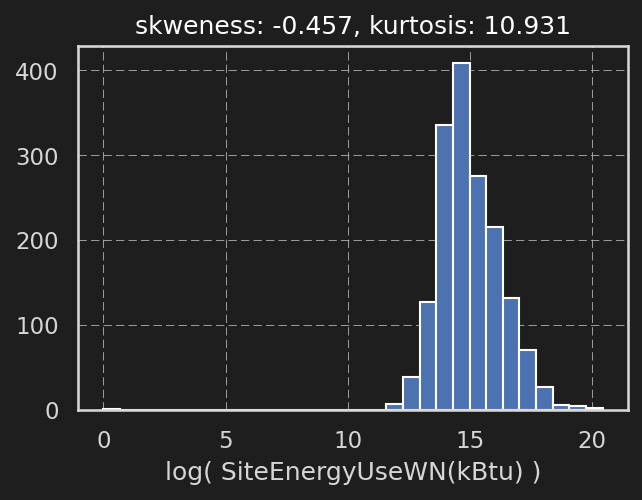

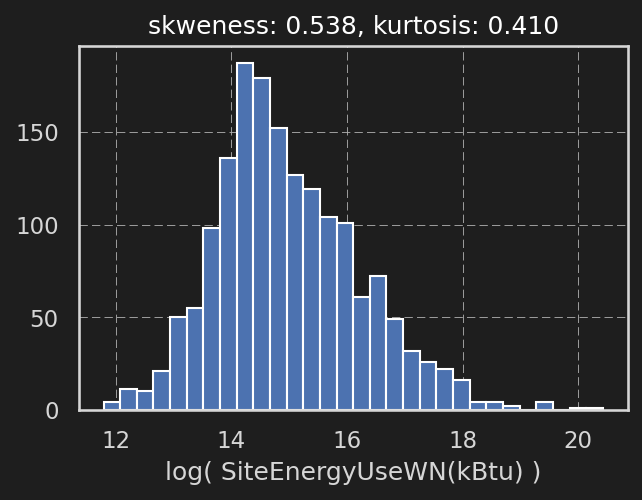

In [275]:
kurtosis = st.kurtosis( y )
skew = st.skew( y )

fig, ax = plt.subplots( figsize=(12*cm,8*cm) )
ax.hist( y, bins=30 )
ax.set_xlabel( f'log( {target} )' )
ax.set_title( f'skweness: {skew:.3f}, kurtosis: {kurtosis:.3f}')

y2 = y[y>5]
kurtosis = st.kurtosis( y2 )
skew = st.skew( y2 )

fig, ax = plt.subplots( figsize=(12*cm,8*cm) )
ax.hist( y2, bins=30 )
ax.set_xlabel( str_out )
ax.set_title( f'skweness: {skew:.3f}, kurtosis: {kurtosis:.3f}')


***
# 1. Definitions

In [276]:
def train_model( model_name, model, param_grid, score='r2' ): 
    # Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
    modelCV = model_selection.GridSearchCV(
        model, # modèle
        param_grid,     # hyperparamètres à tester
        cv=5,           # nombre de folds de validation croisée
        scoring=score,   # score à optimiser
        n_jobs=-1
    )

    t0 = time.time()
    modelCV.fit(X_train, y_train)
    model_to_results( model_name, modelCV, X_test, time.time()-t0 )

    return modelCV

def log_transfrom( x ):
    return np.log( x + (1.-x.min()))

def print_coefs( coefs, features ):
    n_features_0 = len( features ) -1

    print('coefficients linear:')
    print(coefs[:n_features_0+1])

    if len( coefs ) > n_features_0+1:
        print('coefficients non-linear:')
        print(coefs[n_features_0+1:])

    print('linear coefs == 0 for :', np.array(features)[ coefs[:n_features_0+1] == 0. ])
    if len( coefs ) > n_features_0+1:
        print('non-linear coefs == 0 for :', np.array(features[1:])[ coefs[n_features_0+1:] == 0. ])

In [277]:
X_GFA_building = df['PropertyGFABuilding(s)'].values.reshape(-1,1)
X_GFA_building = np.log( 1. + X_GFA_building )

X_GFA_parking = np.log( 1. + X_ParkingGFA.reshape(-1,1) )

df['Neighborhood'] = df['Neighborhood'].astype('category')
print( df['Neighborhood'].cat.categories )

X_neighborhood = np.zeros( (len(df), len(df['Neighborhood'].cat.categories) ) )
X_neighborhood[range(len(df)), df['Neighborhood'].cat.codes] = X_GFA_building.ravel()

# for verification
# for i in range(100):
#     print(i, df['Neighborhood'].cat.codes.values[i],  X_neighborhood[i] )

Index(['ballard', 'central', 'delridge', 'downtown', 'east',
       'greater duwamish', 'lake union', 'magnolia / queen anne', 'north',
       'northeast', 'northwest', 'southeast', 'southwest'],
      dtype='object')


In [278]:
# X = np.hstack ([X_ParkingGFA.reshape(-1,1)] + [ Xi.reshape(-1,1) * X_propotion_PropertyUseTypeGFA for Xi in X_propotion_energy.transpose()])

X_propotion_PropertyUseTypeGFA = np.log( X_propotion_PropertyUseTypeGFA + (1.-X_propotion_PropertyUseTypeGFA.min()))
X_propotion_energy = np.log( X_propotion_energy + (1.-X_propotion_energy.min()))

df['NumberofBuildings'] = np.log( df['NumberofBuildings'] + (1.-df['NumberofBuildings'].min()))
df['NumberofFloors'] = np.log( df['NumberofFloors'] + (1.-df['NumberofFloors'].min()))

# X = np.hstack ([X_GFA_parking] + [ Xi.reshape(-1,1) * X_GFA for Xi in X_propotion_energy.transpose()])
X = np.hstack ( [np.ones((len(y),1)) ] + [X_GFA_parking]
    + [X_GFA_building] + [X_propotion_PropertyUseTypeGFA]
    + [X_neighborhood]
    # + [df['Neighborhood'].astype('category').cat.codes.values.reshape(-1,1)]
    + [X_propotion_energy] + [df[['NumberofBuildings', 'NumberofFloors','YearBuilt']].values] )

features_X = ['cste', 'GFA_parking', 'GFA_building'] \
    + df['Neighborhood'].cat.categories.tolist() \
    + PropertyUseTypes.tolist() \
    + features_3 + ['NumberofBuildings', 'NumberofFloors','YearBuiltCateg']
# X[-4] = np.log( 1 + X[-4] )
# X[-5] = np.log( 1 + X[-5] )

# X = np.hstack( (X, X[:,1:]**2))

X_train, X_test, y_train, y_test = model_selection.train_test_split( X, y, random_state=0)
scaler = preprocessing.StandardScaler().fit( X_test )
X_test = scaler.transform( X_test )
X_train = scaler.transform( X_train )


In [279]:
print( 'X_train:', X_train.shape )
# display( len( df['Neighborhood'].value_counts() ) )
# df['Neighborhood'].astype('category').cat.codes

X_train: (1236, 43)


In [280]:
print( 'X_parking:', X_ParkingGFA.shape )
print( 'X_PropertyUseType:', X_propotion_PropertyUseTypeGFA.shape )
print( 'X_propotion_energy:', X_propotion_energy.shape )
print('features_1:\n', features_1)
print('\nfeatures_2:\n', features_2)
print('\nfeatures_3:\n', features_3)
print('\nfeatures_4:\n', features_4)
print('\nfeatures_X:\n', features_X)


X_parking: (1649,)
X_PropertyUseType: (1649, 21)
X_propotion_energy: (1649, 3)
features_1:
 ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'NumberofBuildings', 'NumberofFloors', 'YearBuiltCateg', 'YearBuilt', 'PropertyGFABuilding(s)']

features_2:
 ['YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEnergyUseWN(kBtu)']

features_3:
 ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']

features_4:
 ['DefaultData', 'ComplianceStatus', 'Outlier']

features_X:
 ['cste', 'GFA_parking', 'GFA_building', 'ballard', 'central', 'delridge', 'downtown', 'east', 'greater duwamish', 'lake union', 'magnolia / queen anne', 'north', 'northeast', 'northwest', 'southeast', 'southwest', 'data center', 'distribution center', 'education', 'entertainment/public assembly', 'lifestyle center', 'manufacturing/industrial plant', 'medical', 'medical office', 'non-refrigerated warehouse', 'office', 'other', 'other - entertainment/public assembly', 'refrigerated warehouse', 'residential - hotel', 

In [281]:
dico_results = {'y_test':y_test}

In [312]:
def plot_results( label ):
    y_test, y_pred = dico_results['y_test'], dico_results[label]['y_pred']

    argsort = y_test.argsort()
    fig, ax = plt.subplots( figsize=(12*cm,8*cm) )
    ax.plot( y_test[argsort], 'r', label='data' )
    ax.plot( y_pred[argsort], 'bo', markersize=2, label=label )
    ax.legend()
    ax.set_xlabel('sample')

    fig, ax = plt.subplots( figsize=(12*cm,8*cm) )
    ax.plot( y_test, y_pred, 'bo', markersize=2, label=f'prediction {label}' )
    xy_optim = [y_test.min(), y_test.max()]
    ax.plot( xy_optim, xy_optim, 'r', label='optimal fit' )
    ax.legend()
    ax.set_xlabel( 'prediction ' + label)
    imin = y_test.argmin()
    print( y_pred[imin], y_test[imin] )

    ax.set_xlabel( str_out )

def model_to_results( name, model, X_test, training_time ):
    dico_results[name] = {'y_pred': model.predict(X_test),
                        'training time': training_time,
                        'model':model }

def print_results( ):
    y_test = dico_results['y_test']
    df_results = pd.DataFrame( index=['training time (sec.)', 'MSE', 'R2 score'])
    for (name, results) in dico_results.items():
        if name == 'y_test' :
            continue
        y_pred = results['y_pred']
        df_results[name] = [results['training time'], 
                            metrics.mean_squared_error(y_test, y_pred),
                            metrics.r2_score(y_test, y_pred) ]
    
    display( df_results )

# 1. Regressor data

(-0.5, 22.0)

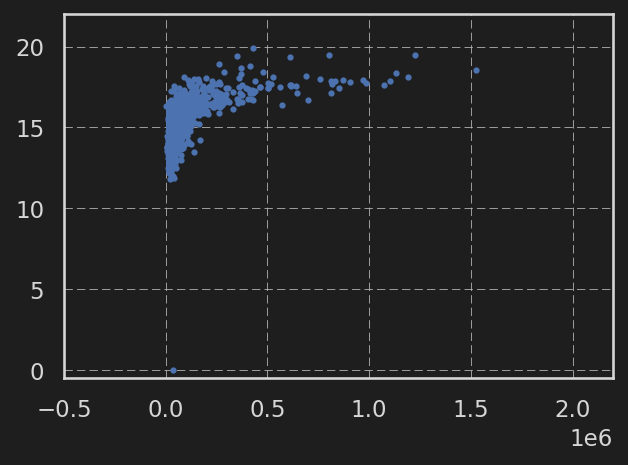

In [283]:
fig, ax = plt.subplots( figsize=(12*cm, 8*cm))
ax.plot( X_propotion_PropertyUseTypeGFA.sum(1) * df['PropertyGFABuilding(s)'], y, 'bo', markersize=2 )
ax.set_xlim([-0.5e6, 2.2e6])
ax.set_ylim([-0.5, 22])

# 1. Dummy Regressor

In [284]:
model_name = 'dummy median'
t0 = time.time()
dr = dummy.DummyRegressor( strategy='median' ).fit( X_train, y_train )
model_to_results( model_name, dr, X_test, time.time()-t0 )

In [285]:
dico_results.keys()

dict_keys(['y_test', 'dummy median'])

,dummy median
training time (sec.),0.000863
MSE,2.121854
R2 score,-0.022876


14.775723727026307 0.0


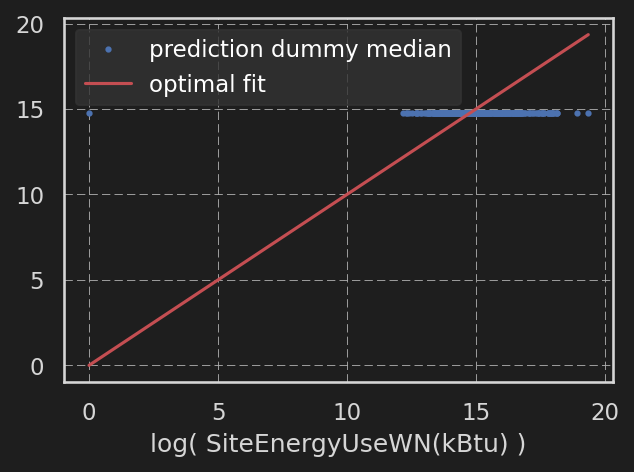

In [286]:
print_results()
plot_results( model_name )

***
# 2. Elastic net

In [287]:
# help( linear_model.ElasticNet )

In [288]:
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import warnings

In [289]:
model_name = 'Elastic net'

# Fixer les valeurs des hyperparamètres à tester
param_grid = {'l1_ratio':np.geomspace(0.5, 0.99, 10),
            'alpha':np.logspace(-5, 1, 20)}

model = train_model( model_name, linear_model.ElasticNet(random_state=0), param_grid )

/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Projetcs/03_energy/.venv/lib64/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.068e+01, tolerance: 1.464e-01
  model = cd_fast.enet_coordinate_descent(
/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Projetcs/03_energy/.venv/lib64/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.465e+01, tolerance: 1.505e-01
  model = cd_fast.enet_coordinate_descent(
/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Pro

In [290]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model.best_params_)

print_coefs( model.best_estimator_.coef_, features_X )

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.0069519279617756054, 'l1_ratio': 0.99}
coefficients linear:
[ 0.          0.08439371  0.80364233  0.13905407 -0.10715098 -0.1099487
  0.06826733  0.03619006  0.01115454  0.11633352  0.04720398 -0.21952734
 -0.          0.03598593  0.          0.01694175 -0.          0.0498711
  0.16191896 -0.14192947 -0.00930796  0.06182991  0.         -0.10988918
 -0.00689956 -0.00503231  0.00568007 -0.01064978  0.00461571 -0.
  0.003631    0.01032253 -0.00578022  0.03088121  0.008658   -0.
  0.01578927  0.06204879 -0.          0.18522731  0.05880454  0.02626979
 -0.01523819]
linear coefs == 0 for : ['cste' 'northeast' 'southeast' 'data center' 'medical'
 'residential - hotel' 'utility' 'Electricity(kBtu)']


,dummy median,Elastic net
training time (sec.),0.000863,2.945190
MSE,2.121854,0.867961
R2 score,-0.022876,0.581585


14.63553771214928 0.0
train MSE: 0.392
train r2: 0.743


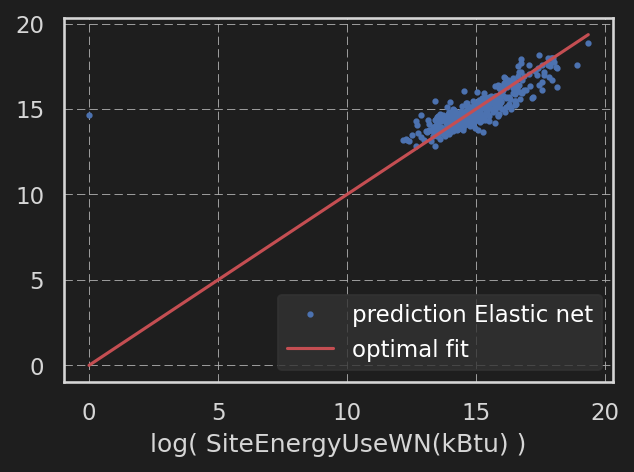

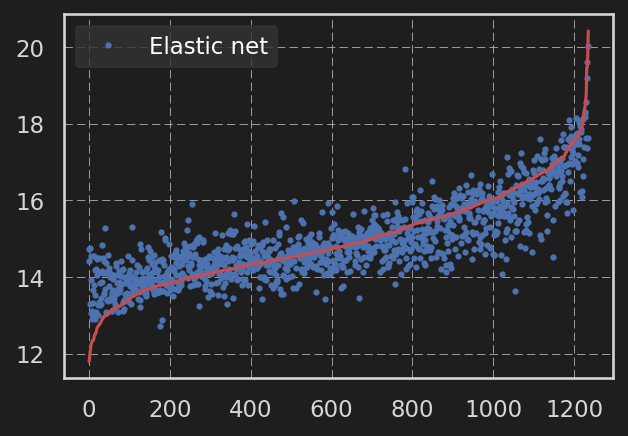

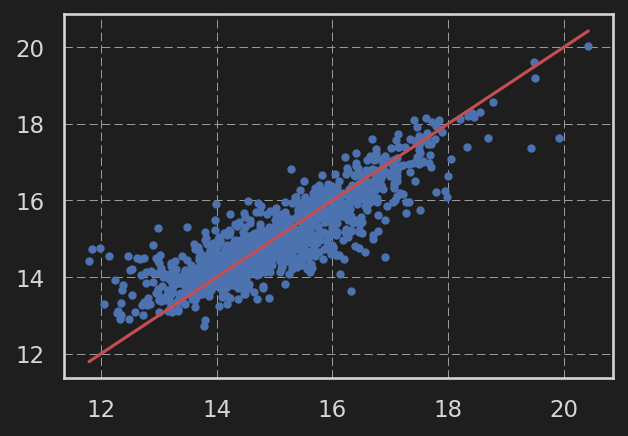

In [291]:
print_results()
plot_results( model_name )

print( 'train MSE: {:.3f}'.format( metrics.mean_squared_error( y_train, elNet.predict(X_train) ) ) )
print( 'train r2: {:.3f}'.format( metrics.r2_score( y_train, elNet.predict(X_train) ) ) )

argsort = y_train.argsort()
fig, ax = plt.subplots( figsize=(12*cm,8*cm))
ax.plot( y_train[argsort], 'r' )
ax.plot( model.predict( X_train )[argsort], 'bo', markersize=2, label=model_name )
ax.legend()

if False:
    fig, ax = plt.subplots( figsize=(12*cm,8*cm))
    ax.plot( [y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r' )
    ax.plot( y_train, model.predict( X_train) , 'bo', markersize=3 )

In [292]:
model_name = 'lasso'
alphas_lasso = np.logspace(-5, 0, 100)
t0 = time.time()
model = linear_model.LassoCV( alphas=alphas_lasso, cv=5 ).fit( X_train, y_train )

model_to_results( model_name, model, X_test, time.time()-t0 )
_, coefs_lasso, _ = linear_model.lasso_path( X_train, y_train, alphas=alphas_lasso )

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
alpha: 0.007564633275546291
(100,)
(43, 100)
(1236, 43)
coefficients linear:
[ 0.          0.08416732  0.80419076  0.13645892 -0.10693705 -0.10947861
  0.06736594  0.03587163  0.01029179  0.11571459  0.0466998  -0.21971112
 -0.          0.03528969  0.          0.01497562 -0.          0.04886114
  0.16103888 -0.14147843 -0.00893774  0.06056847  0.         -0.10953176
 -0.00613819 -0.00449127  0.00518578 -0.00917699  0.00420339 -0.
  0.00314097  0.0099053  -0.00531853  0.02991861  0.00773556 -0.
  0.01522893  0.06129407 -0.          0.18405976  0.05774883  0.02454926
 -0.01461256]
linear coefs == 0 for : ['cste' 'northeast' 'southeast' 'data center' 'medical'
 'residential - hotel' 'utility' 'Electricity(kBtu)']


,dummy median,Elastic net,lasso
training time (sec.),0.000863,2.945190,0.121860
MSE,2.121854,0.867961,0.868619
R2 score,-0.022876,0.581585,0.581267


14.641064384602942 0.0


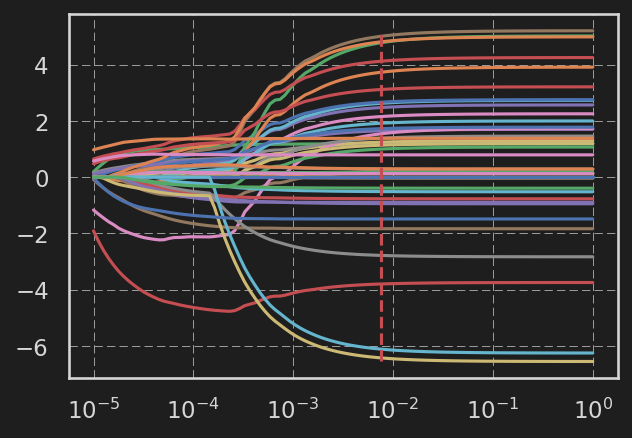

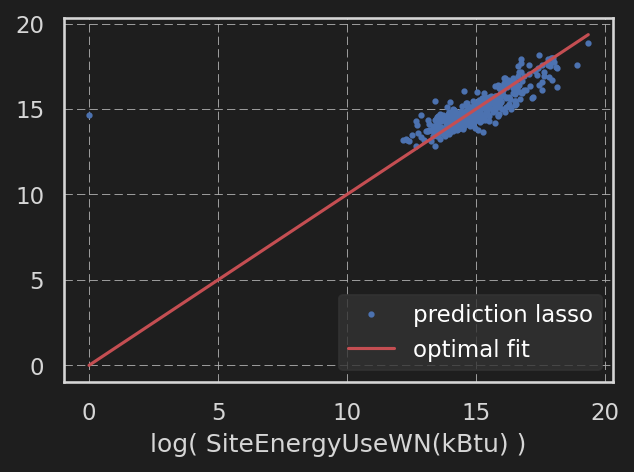

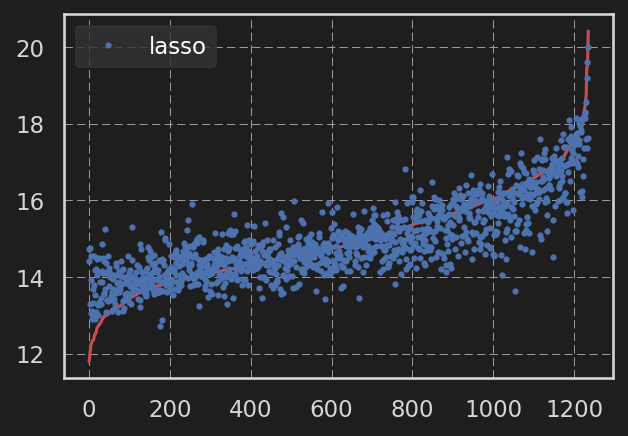

In [293]:
alpha_lassoCV = model.alpha_
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print( 'alpha:', alpha_lassoCV)


print( alphas_lasso.shape )
print(coefs_lasso.shape)
print(X_train.shape)

print_coefs( model.coef_, features_X )

fig, ax = plt.subplots( figsize=(12*cm,8*cm) )
ax.semilogx( alphas_lasso, coefs_lasso.transpose() )
ax.plot( [alpha_lassoCV,]*2, [coefs_lasso.min(), coefs_lasso.max()], 'r--' )


print_results()
plot_results( model_name )

argsort = y_train.argsort()
fig, ax = plt.subplots( figsize=(12*cm,8*cm) )
ax.plot( y_train[argsort], 'r' )
ax.plot( model.predict( X_train )[argsort], 'bo', markersize=2, label=model_name )
ax.legend()

***
# 3. SVR

In [294]:
from sklearn.svm import LinearSVR
# help( LinearSVR )

model_name = 'Linear SVR'

# Fixer les valeurs des hyperparamètres à tester
param_grid = {'loss':['epsilon_insensitive', 'squared_epsilon_insensitive'],
            'C':np.logspace(-5, 10, 20)}


model = train_model( model_name, LinearSVR( dual=False ), param_grid)

/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Projetcs/03_energy/.venv/lib64/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Projetcs/03_energy/.venv/lib64/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Projet

,dummy median,Elastic net,lasso,Linear SVR
training time (sec.),0.000863,2.945190,0.121860,0.215447
MSE,2.121854,0.867961,0.868619,0.864120
R2 score,-0.022876,0.581585,0.581267,0.583436


14.560972425744971 0.0


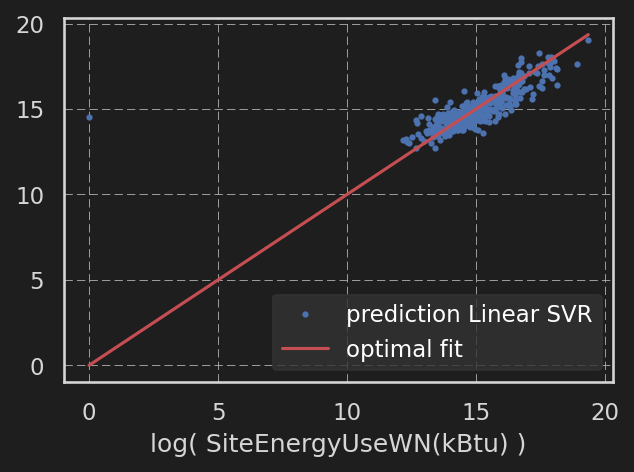

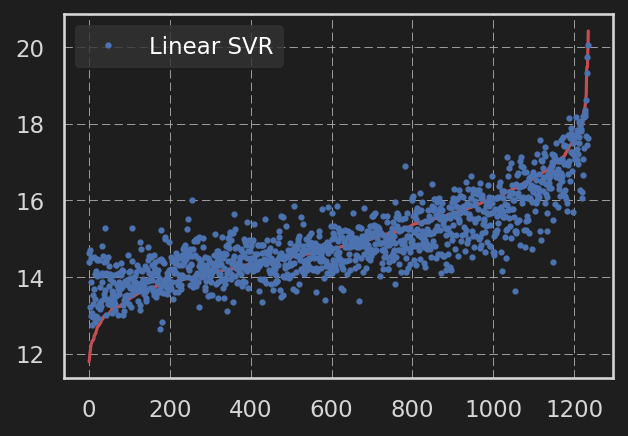

In [295]:
print_results()
plot_results( model_name )

argsort = y_train.argsort()
fig, ax = plt.subplots( figsize=(12*cm,8*cm) )
ax.plot( y_train[argsort], 'r' )
ax.plot( model.predict( X_train )[argsort], 'bo', markersize=2, label=model_name )
ax.legend()

***
# Kernel Ridge

In [296]:
from sklearn import kernel_ridge

model_name = 'Kernel ridge'

# Fixer les valeurs des hyperparamètres à tester
param_grid = {
            'alpha':np.logspace(-4, -2, 10),
            'gamma':np.logspace(-4, -2, 10),
            }

model = train_model( model_name, kernel_ridge.KernelRidge(kernel='rbf'), param_grid )

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.000774263682681127, 'gamma': 0.0002782559402207126}


,dummy median,Elastic net,lasso,Linear SVR,Kernel ridge
training time (sec.),0.000863,2.945190,0.121860,0.215447,14.432354
MSE,2.121854,0.867961,0.868619,0.864120,0.861102
R2 score,-0.022876,0.581585,0.581267,0.583436,0.584891


14.54112784993049 0.0


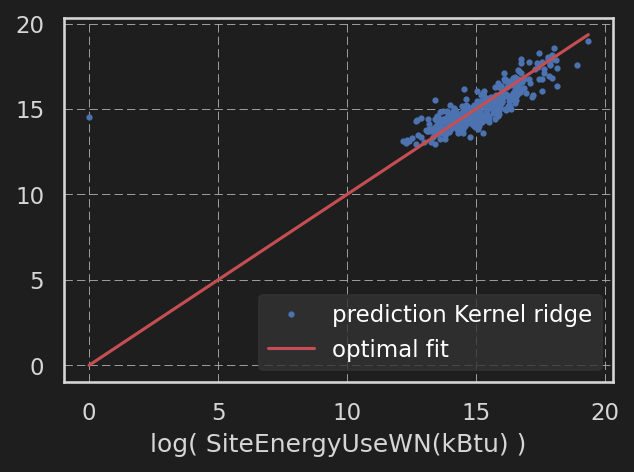

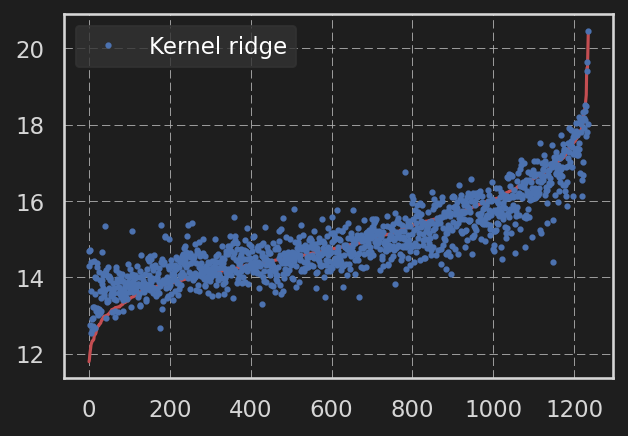

In [297]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model.best_params_)


print_results()
plot_results( model_name )

argsort = y_train.argsort()
fig, ax = plt.subplots( figsize=(12*cm,8*cm) )
ax.plot( y_train[argsort], 'r' )
ax.plot( model.predict( X_train )[argsort], 'bo', markersize=2, label=model_name )
ax.legend()

***
# Kernel SVR

In [298]:
help( svm.SVR )

Help on class SVR in module sklearn.svm._classes:

class SVR(sklearn.base.RegressorMixin, sklearn.svm._base.BaseLibSVM)
 |  SVR(*, kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
 |  
 |  Epsilon-Support Vector Regression.
 |  
 |  The free parameters in the model are C and epsilon.
 |  
 |  The implementation is based on libsvm. The fit time complexity
 |  is more than quadratic with the number of samples which makes it hard
 |  to scale to datasets with more than a couple of 10000 samples. For large
 |  datasets consider using :class:`~sklearn.svm.LinearSVR` or
 |  :class:`~sklearn.linear_model.SGDRegressor` instead, possibly after a
 |  :class:`~sklearn.kernel_approximation.Nystroem` transformer or
 |  other :ref:`kernel_approximation`.
 |  
 |  Read more in the :ref:`User Guide <svm_regression>`.
 |  
 |  Parameters
 |  ----------
 |  kernel : {'linear', 'poly', 'rbf', 'sigmoid', 'precomput

In [299]:
model_name = 'Kernel SVR'

# Fixer les valeurs des hyperparamètres à tester
param_grid = {
            'C':np.logspace(0, 4, 10),
            'gamma':np.logspace(-5, -3, 10),
            }

model = train_model( model_name, svm.SVR(kernel='rbf'), param_grid )

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'C': 59.94842503189409, 'gamma': 0.001}


,dummy median,Elastic net,lasso,Linear SVR,Kernel ridge,Kernel SVR
training time (sec.),0.000863,2.945190,0.121860,0.215447,14.432354,21.214120
MSE,2.121854,0.867961,0.868619,0.864120,0.861102,0.873790
R2 score,-0.022876,0.581585,0.581267,0.583436,0.584891,0.578775


14.580911162881078 0.0


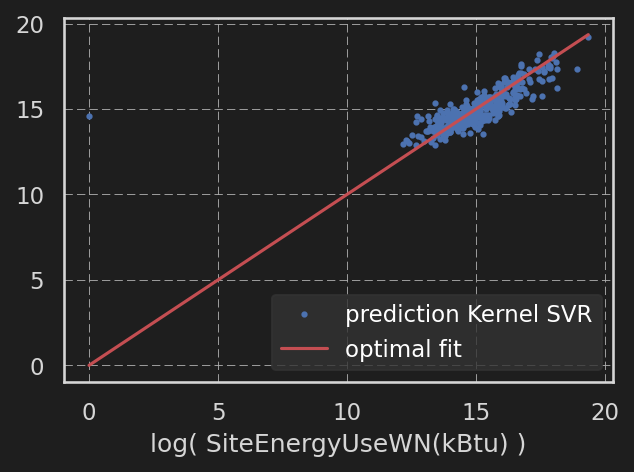

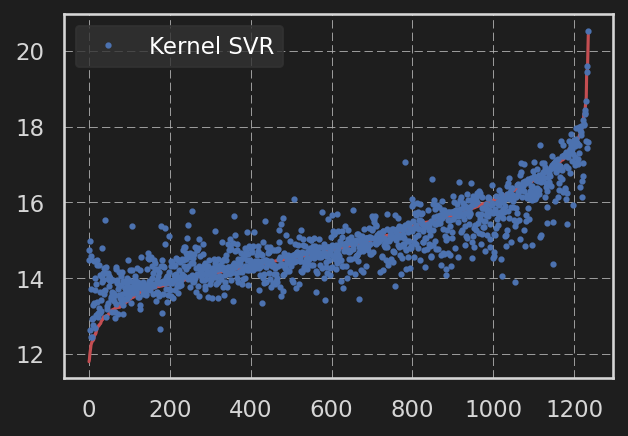

In [300]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model.best_params_)


print_results()
plot_results( model_name )

argsort = y_train.argsort()
fig, ax = plt.subplots( figsize=(12*cm,8*cm) )
ax.plot( y_train[argsort], 'r' )
ax.plot( model.predict( X_train )[argsort], 'bo', markersize=2, label=model_name )
ax.legend()

***
# Random Forest

In [306]:
from sklearn.ensemble import RandomForestRegressor
# help( RandomForestRegressor )

model_name = 'Random forest'
param_grid = {
    'n_estimators':[300, 400, 500],
    'min_samples_split': [2, 8, 16],
    'max_depth':[None, 10, 40, 100]
}

model = train_model( model_name, RandomForestRegressor(), param_grid )

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': None, 'min_samples_split': 8, 'n_estimators': 400}


,dummy median,Elastic net,lasso,Linear SVR,Kernel ridge,Kernel SVR,Random forest
training time (sec.),0.000863,2.945190,0.121860,0.215447,14.432354,21.214120,59.526095
MSE,2.121854,0.867961,0.868619,0.864120,0.861102,0.873790,0.929527
R2 score,-0.022876,0.581585,0.581267,0.583436,0.584891,0.578775,0.551906


14.776294402128526 0.0


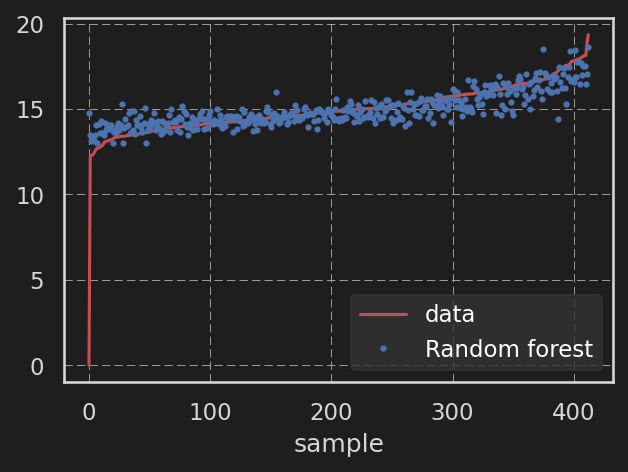

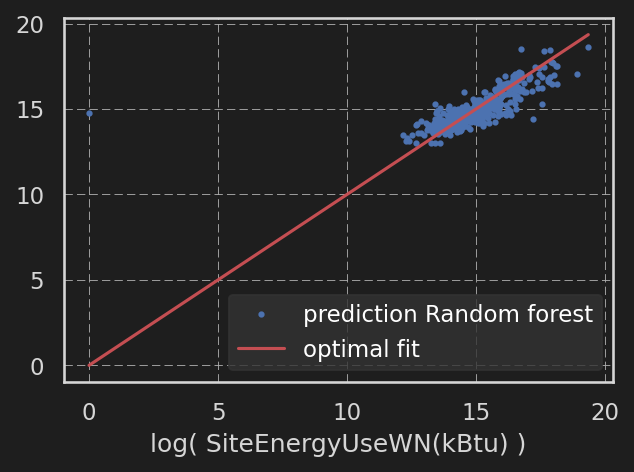

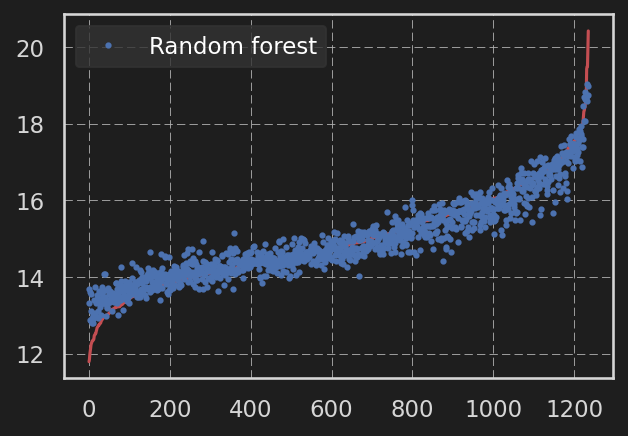

In [313]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model.best_params_)


print_results()
plot_results( model_name )

argsort = y_train.argsort()
fig, ax = plt.subplots( figsize=(12*cm,8*cm) )
ax.plot( y_train[argsort], 'r' )
ax.plot( model.predict( X_train )[argsort], 'bo', markersize=2, label=model_name )
ax.legend()

***
# LightGBM

In [326]:
import lightgbm as lgb

model_name = 'Light GBM'
param_grid = {
    'n_estimators': [50, 100, 150, 200,300],
    # 'max_features': [ i  for i in range(1, X.shape[1], 10) ] + [X.shape[1]],
    'subsample': np.arange(0.1, 1.1, 0.1),
    'learning_rate': [0.001, 0.01, 0.1, 1.0],
    'max_depth': np.arange(1, 5),
}

model = train_model( model_name, lgb.LGBMRegressor(), param_grid )

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300, 'subsample': 0.1}


,dummy median,Elastic net,lasso,Linear SVR,Kernel ridge,Kernel SVR,Random forest,Light GBM
training time (sec.),0.000863,2.945190,0.121860,0.215447,14.432354,21.214120,59.526095,19.743163
MSE,2.121854,0.867961,0.868619,0.864120,0.861102,0.873790,0.929527,0.899953
R2 score,-0.022876,0.581585,0.581267,0.583436,0.584891,0.578775,0.551906,0.566162


14.583776626225285 0.0


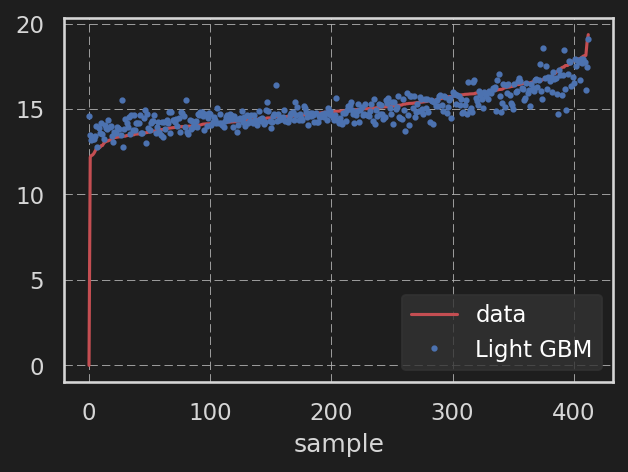

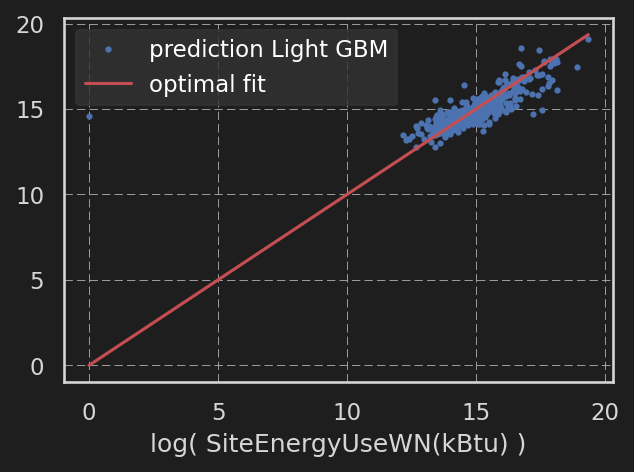

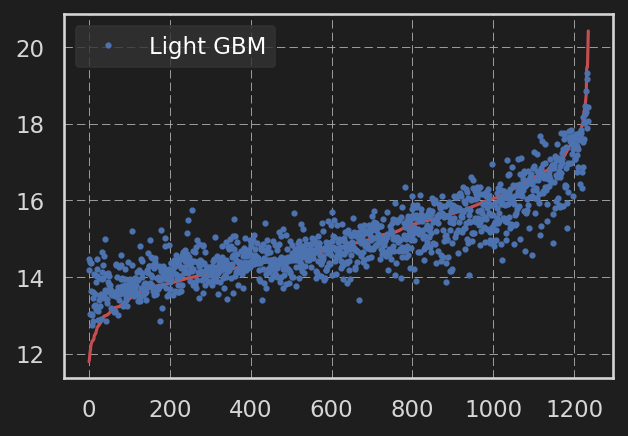

In [327]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model.best_params_)


print_results()
plot_results( model_name )

argsort = y_train.argsort()
fig, ax = plt.subplots( figsize=(12*cm,8*cm) )
ax.plot( y_train[argsort], 'r' )
ax.plot( model.predict( X_train )[argsort], 'bo', markersize=2, label=model_name )
ax.legend()